## Diagnosing Pediatric Pneumonia from Chest X-Rays Using a Convolutional Neural Network  

### Caitlin Streamer

----------------------------------------------------------------------------------------------------------------------

**Problem statement:**   
Medical imaging, such as x-rays, are used to help diagnose certain conditions. The limited availability of highly trained doctors who can interpret these images, however, can lead to a slow diagnostic process which delays needed treatment. Childhood Pneumonia is one such condition that when diagnosed early can be life saving. According to the World Health Organization, Pneumonia is responsible for 16% of child deaths under 5 years old. In an attempt to address this problem, I will create a machine learning model to diagnose pediatric Pneumonia from chest x-rays in order to expedite the disease screening process. I will optimize for sensitivty to reduce false negatives and use AUC-ROC as my evaluation metric.  

**Proposed methods and approaches:**  
I will create a binary classification Convolutional Neural Network using Keras and TensorFlow. Time permitting, I hope to create a 3 class CNN to distiguish viral from bacterial Pneumonia. I will also use the Keras Image Augmentation API to standardize and balance my classes.  


**Data Source:**  
I am utilizing a dataset from a recently published paper: 

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2, http://dx.doi.org/10.17632/rscbjbr9sj.2

In this study, over 5,000 x-rays where obtained from children ages 1-5 at Guangzhou Women and Children’s Medical Center, Guangzhou China during regular clincial visits. The images were labeled by 2 expert physicians. 

----------------------------------------------------------------------------------------------------------------------

#### Import and Format Images 

The dataset I obtained is composed of a train and test folder, each with Normal and Pneumonia sub-folders. Within the condition type folders there are jpeg chest x-ray images. In the test data there are 390 Pneumonia x-rays and 234 normal. In the train data there are 3,883 Pneumonia x-rays and 1,349 normal.  

In order to load the images, I will define directory paths in order to first create a dataframe of each image URL and its associated label. I will define label = 1 as Pneumonia and label = 0 as normal. 

In [39]:
# Import libraries

import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from skimage.io import imread

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Define directory paths for the images 
train_normal_path = Path('data/train/NORMAL')
train_pne_path = Path('data/train/PNEUMONIA')

test_normal_path = Path('data/test/NORMAL')
test_pne_path = Path('data/test/PNEUMONIA')

In [3]:
# Collect image paths from each directory 
train_normal = train_normal_path.glob('*.jpeg')
train_pne = train_pne_path.glob('*.jpeg')

test_normal = test_normal_path.glob('*.jpeg')
test_pne = test_pne_path.glob('*.jpeg')

In [4]:
# Create train and test lists with the image paths and label (label = 0 NORMAL, label = 1 PNEUMONIA)
train = []
for pic in train_normal:
    train.append((pic, 0))
    
for pic in train_pne:
    train.append((pic, 1))
    
test = []
for pic in test_normal:
    test.append((pic, 0))

for pic in test_pne:
    test.append((pic, 1))

In [5]:
# Create dataframes from the train and test lists 
train = pd.DataFrame(train, columns = ['image_path', 'label'])
test = pd.DataFrame(test, columns = ['image_path', 'label'])

In [6]:
# Inspect train
train.head()

,image_path,label
0,data/train/NORMAL/NORMAL2-IM-0927-0001.jpeg,0
1,data/train/NORMAL/NORMAL2-IM-1056-0001.jpeg,0
2,data/train/NORMAL/IM-0427-0001.jpeg,0
3,data/train/NORMAL/NORMAL2-IM-1260-0001.jpeg,0
4,data/train/NORMAL/IM-0656-0001-0001.jpeg,0


In [7]:
# Shuffle dataframe so that the classes aren't in order
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True);

In [8]:
# Inspect train and test shape - test set is significantly smaller 
train.shape, test.shape

((5232, 2), (624, 2))

#### Image Analysis 

In order to determine the amount of preprocessing required before modeling, I will investigate the images themselves. I will focus on answering the following questions: 

1) Is the data unbalanced?   
2) Are the images the same size?   
3) Are the images grayscale or do they have multiple color channels?  

I will start by first showing a few example x-rays to get a feel for what I'm dealing with. 

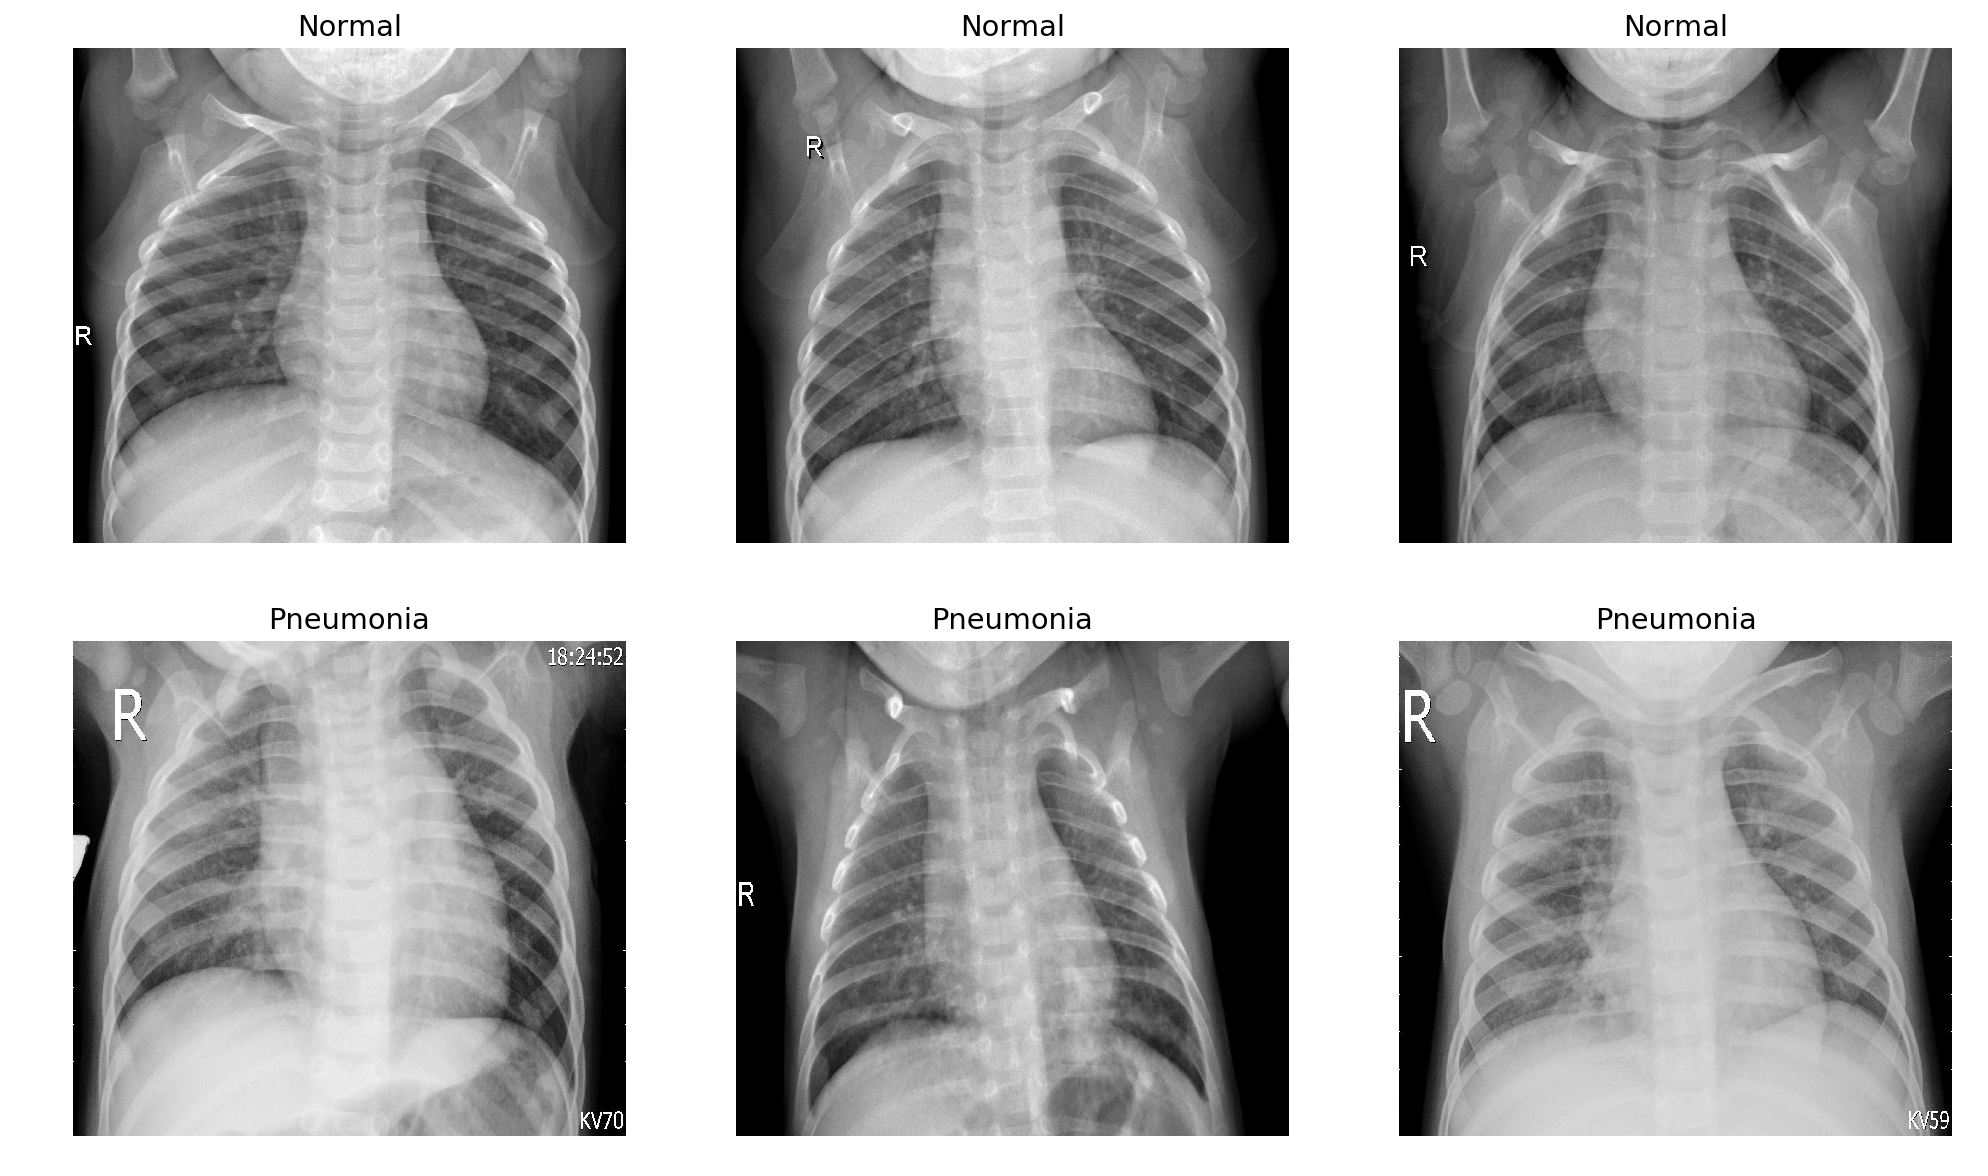

In [10]:
# Select first 3 normal and pneumonia images 
normal = (train[train['label']==0]['image_path'].head(3)).tolist()
pneumonia = (train[train['label']==1]['image_path'].head(3)).tolist()

# Initiate plots 
fig, ax = plt.subplots(2,3, figsize = (15,10))

# Iterate through both sets of 3 images
for i in range(3):
    
    # Read images 
    norm = imread(normal[i])
    pne = imread((pneumonia[i]))
    
    # View images
    ax[0, i].imshow(norm, cmap = 'gray')
    ax[1, i].imshow(pne, cmap = 'gray')
    
    # Labels
    ax[0, i].set_title('Normal')
    ax[1, i].set_title('Pneumonia')
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[1, i].set_aspect('auto')
    ax[0, i].set_aspect('auto');

From the x-rays above, it is not immediately obvious to the untrained eye which cases are which. Luckily there are other methods by which we can better visualize the difference.  

Next I will answer question 1: is the data unbalanced?

In [17]:
# Determine fraction of images in each class 
train['label'].value_counts(normalize = True)

1    0.742164
0    0.257836
Name: label, dtype: float64

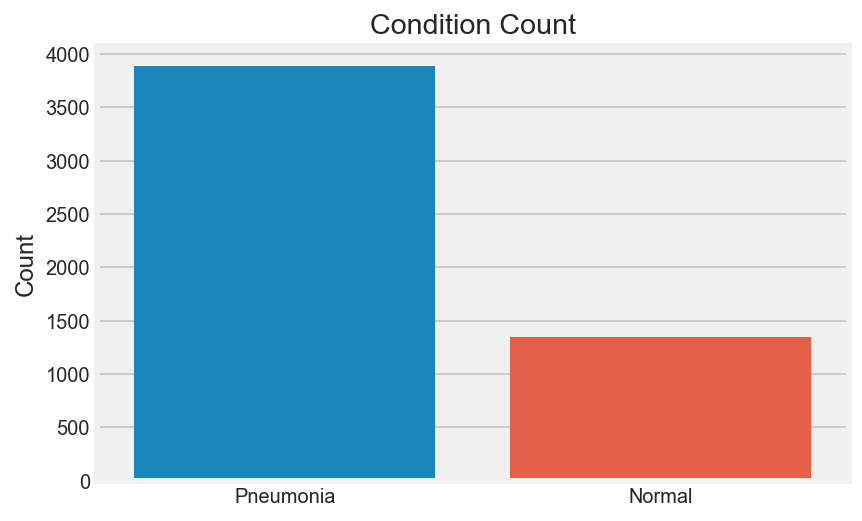

In [40]:
# Visual of class balance 
class_balance = train['label'].value_counts()
sns.barplot(['Pneumonia', 'Normal'], class_balance)
plt.ylabel('Count')
plt.title('Condition Count');

You can see that there are actually more cases of Pneumonia in my dataset than normal ones. Unbalanced classes are not uncommon with medical data.  

Classification algorithms perform better with an even ratio of classes otherwise the minority class is typically underrepresented as a rare event. I will therefore need to balance the classes by using data agumentation to oversample the minority (normal) class.  

Next I address questions 2 and 3: Is the data the same shape? 

In [12]:
# Identify number of color channels in the train 
train_list = train['image_path'].tolist()
color = []
for i in range(len(train_list)):
    read = cv2.imread(str(train_list[i]))
    color.append(read.shape[2])
set(color)

{3}

In [14]:
# Identify number of color channels in the test 
test_list = test['image_path'].tolist()
color = []
for i in range(len(test_list)):
    read = cv2.imread(str(test_list[i]))
    color.append(read.shape[2])
set(color)

{3}

All images in the train and test have 3 color channels. Since I'm using opencv, which reads images as BGR, I will have to convert images to RBG during preprocessing. 

In [15]:
# Identify unqiue number of image sizes in the train
shape = []
for i in range(len(train_list)):
    read = cv2.imread(str(train_list[i]))
    shape.append(read.shape[:2])
len(set(shape))

4376

In [16]:
# Identify unqiue number of image sizes in the train
shape = []
for i in range(len(test_list)):
    read = cv2.imread(str(test_list[i]))
    shape.append(read.shape[:2])
len(set(shape))

598

There are many different image shapes in both the train and test sets. I will have to standardize the image size in preprocessing in order to make all the images the same shape, which will improve my modeling.  

Next I will plot histograms of normal and Pneumonia cases to get a feel for the color distribution 

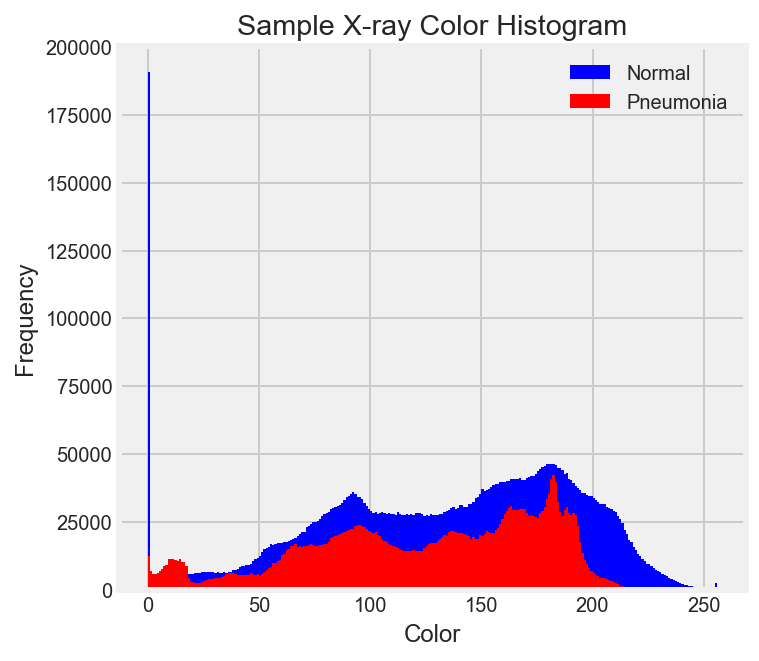

In [55]:
# Compare histograms of normal and pneumonia x-rays
fig = plt.figure(figsize = (5,5))

# Identify a normal and pneumonia x-rays
image_norm = cv2.imread(str(train_list[0]))
image_pne = cv2.imread(str(test_list[0]))

# Plot histograms of images
plt.hist(image_norm.ravel(),256,[0,256], color = 'b', label = 'Normal')
plt.hist(image_pne.ravel(), 256, [0, 256], color = 'r', label = 'Pneumonia')

# Labels
plt.ylabel('Frequency')
plt.xlabel('Color')
plt.title('Sample X-ray Color Histogram')
plt.legend(loc = 'best');

#### Image Processing

From my image analysis above, I determined that I will need to standardize the shape of all images and augment the minority normal class in the train test to artificially balance my classes. I will also need to preprocesses the target label class in order to convert class vectors to binary class matrices. 

In [56]:
# Standardize shape, convert to float

In [57]:
# Data augmentation

In [58]:
# Preprocess y (labels)